# SC qubits - testing the sc_qubits module (2$\alpha$)

## Initialization (load modules etc.)

In [3]:
%pylab inline

from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import sc_qubits2 as qubit  # import the superconducting circuit module

from qutip import *

Populating the interactive namespace from numpy and matplotlib


C:\Users\drjen\Miniconda3\envs\py34\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['entropy', 'squeeze', 'identity', 'shape', 'info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## The Transmon and Cooper pair box

$H_\text{CPB}=4E_\text{C}(\hat{n}-n_g)^2+\frac{1}{2}E_\text{J}(|n\rangle\langle n+1|+\text{h.c.})$

In [4]:
CPB = qubit.Transmon(
    EJ = 40.0,
    EC = 1.0,
    ng = 0.0,
    ncut = 30
    )

In [3]:
CPB

Cooper pair box -- PARAMETERS -------
EC	: 1.0
EJ	: 40.0
ncut	: 30
ng	: 0.0
Hilbert space dimension	: 61


[====================] 100% Done.


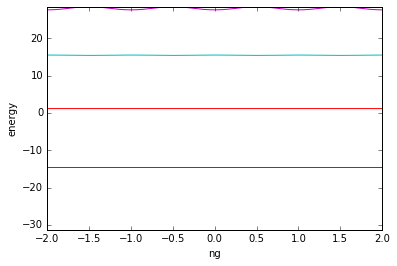

In [5]:
ng_list = np.linspace(-2, 2, 220)
CPB.plot_evals_vs_paramvals('ng', ng_list, evals_count=5, subtract_ground=False, filename="./data/CPB_E_vs_ng")

In [5]:
ng_list = np.linspace(-2, 2, 220)
tst = CPB.get_evals_vs_paramvals('ng', ng_list, evals_count=4, subtract_ground=False, filename="./data/CPB_E_vs_ng")


[====================] 100.0% Done.



[====================] 100.0% Done.


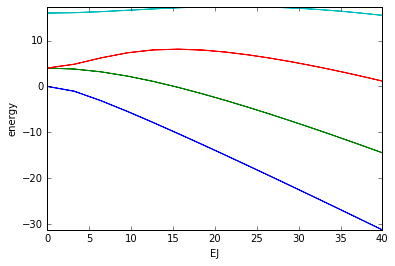

In [6]:
CPB.ng = 0.0
ej_vals = CPB.EJ * np.cos(linspace(-pi/2, pi/2, 40))
CPB.plot_evals_vs_paramvals('EJ', ej_vals, evals_count=4, subtract_ground=False)

In [5]:
CPB.plot_n_wavefunction(esys=None, which=3, mode='real')

NameError: name 'CPB' is not defined

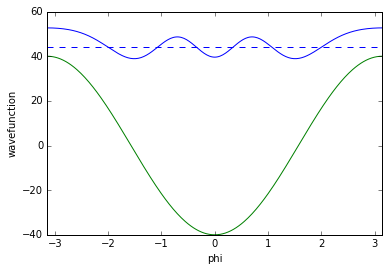

In [8]:
CPB.plot_phi_wavefunction(esys=None, which=6, mode='real')

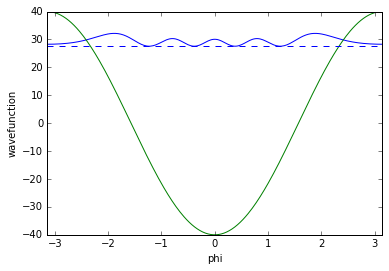

In [9]:
CPB.plot_phi_wavefunction(esys=None, which=4, mode='abs2')

### Charge matrix elements

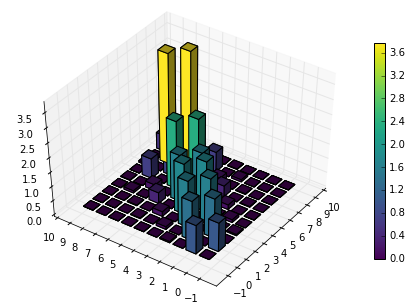

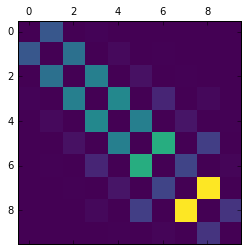

In [10]:
CPB.EJ  = 40
CPB.ncut = 60
nmat = CPB.matrixelements('n_operator', esys=None, evals_count=10)
qubit.plot_matrixelements(nmat, mode='abs')

## Fluxonium qubit

$H_\text{fl}=-4E_\text{C}\partial_\phi^2-E_\text{J}\cos(\phi-\varphi_\text{ext}) +\frac{1}{2}E_L\phi^2$

In [11]:
fluxonium = qubit.Fluxonium(
    EJ = 8.9,
    EC = 2.5,
    EL = 0.5,
    flux = 0.0,
    cutoff = 110
)

In [12]:
fluxonium

fluxonium -- PARAMETERS -------
EC	: 2.5
EJ	: 8.9
EL	: 0.5
cutoff	: 110
flux	: 0.0
Hilbert space dimension	: 110

In [13]:
fluxonium.eigenvals()

array([ -4.28338463,   4.47506063,   4.69616798,   6.71864972,
        12.64960539,  15.28847499])


[====================] 100.0% Done.


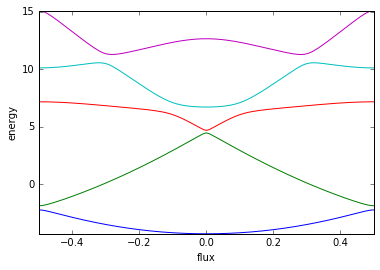

In [14]:
flux_list = np.linspace(-0.5, 0.5, 151)
fluxonium.plot_evals_vs_paramvals('flux', flux_list, evals_count=5)


[====================] 100.0% Done.


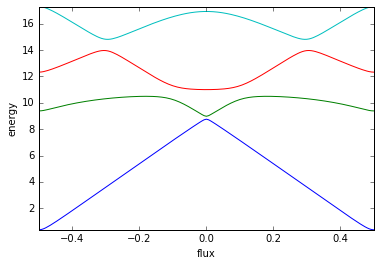

In [5]:
fluxonium.plot_evals_vs_paramvals('flux', flux_list, evals_count=5, subtract_ground=True)

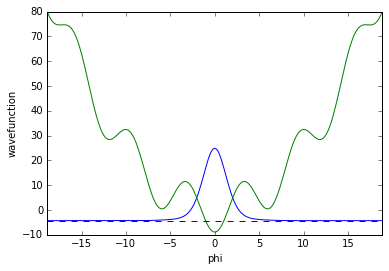

In [15]:
fluxonium.plot_wavefunction(esys=None, which=0, mode='real')

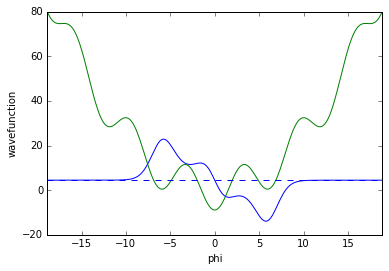

In [16]:
fluxonium.plot_wavefunction(esys=None, which=1, mode='real')

### Matrix elements

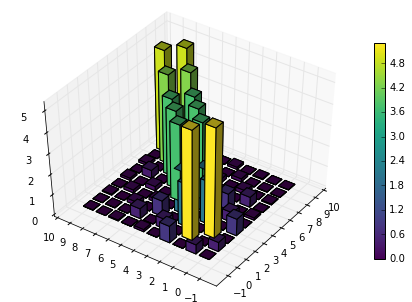

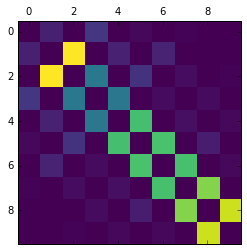

In [17]:
phimat = fluxonium.matrixelements('phi_operator', esys=None, evals_count=10)
qubit.plot_matrixelements(phimat)

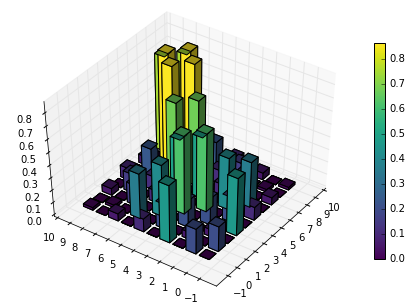

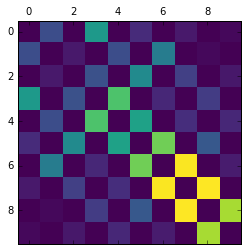

In [18]:
nmat = fluxonium.matrixelements('n_operator', esys=None, evals_count=10)
qubit.plot_matrixelements(nmat)

### Colormap Plotting

#### Defining Fluxonium and the coupled Hamiltonian

In [21]:
fluxonium = qubit.Fluxonium(
    EJ = 7.92393454,
    EC = 0.47252495,
    EL = 0.24801778,
    flux = 0.0,
    cutoff = 110,
    truncated_dim = 8
)

resonator = qubit.Oscillator(
    omega = 4.95,
    truncated_dim=4  # up to 3 photons (0,1,2,3)
)

hilbertspc = qubit.HilbertSpace([fluxonium, resonator])

# Get resonator creation and annihilation operators (full product Hilbert space)
a = hilbertspc.annihilate(resonator)

# Get resonator Hamiltonian (full product Hilbert space)
hres = hilbertspc.diag_hamiltonian(resonator)

g = 0.06957683  

def hamiltonian(flux):
    fluxonium.flux = flux
    
    _, evecs = fluxonium.eigensys(fluxonium.truncated_dim)
    gmat = g * qubit.matrixelem_table(fluxonium.n_operator(), evecs)   # coupling constants
    
    h_flux = hilbertspc.diag_hamiltonian(fluxonium)
    v = sum([gmat[j][k] * hilbertspc.hubbard_operator(j,k,fluxonium) for j in range(fluxonium.truncated_dim) for k in range(fluxonium.truncated_dim)])
    
    return (h_flux + hres + v*(a + a.dag()))

#### Finding eigenstates and eigenenergies

In [22]:
flux_list = np.linspace(0, 1, 320)
eigvals = 15
eval_list = [hamiltonian(flux).eigenenergies(eigvals=eigvals) for flux in flux_list]
estates_list = [hamiltonian(flux).eigenstates(eigvals=eigvals) for flux in flux_list]

#### Data

In [23]:
x = flux_list
y = np.array(eval_list).T #Reshaping data to use in the plotting function

t = [[qutip.expect(a.dag()*a, estates_list[i][1][p]) for i in range(len(flux_list))] for p in range (eigvals)]
    # parameter on which the coloring depends
    # expectation values of a.dag()*a 

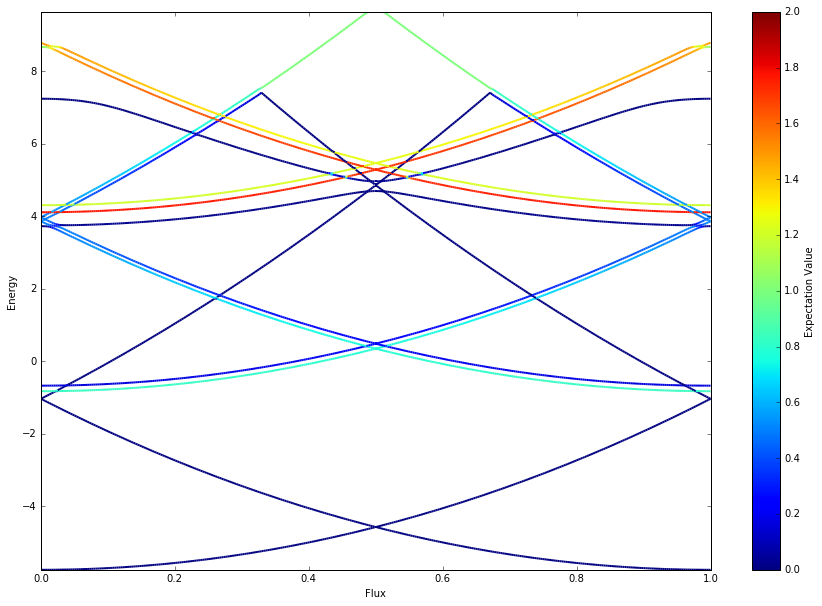

In [25]:
qubit.spectrum_vs_param_colored_plot('Flux', x, 'Energy', y, 'Expectation Value', t, norm_range=(0,2))

## The symmetric $0-\pi$ qubit (no coupling to the $\chi$-mode)

$H_\text{sym}=-2E_\text{CJ}\partial_\phi^2-2E_{\text{C}\Sigma}\partial_\theta^2-2E_\text{J}\cos\theta\cos(\phi-\varphi_\text{ext}/2)+E_L\phi^2+2E_\text{J}$

In [19]:
# parameters for the 0-\pi circuit

phitheta_grid = qubit.GridSpecifications(
    np.asarray([ 
        [-12*pi, 12*pi, 300], # phi variable
        [-pi/2, 3*pi/2, 40]   # theta variable (2pi periodic!)
    ])
    )



EJ_CONST = 1/3.95  # note that EJ and ECJ are interrelated

zero_pi = qubit.SymZeroPi(
    grid = phitheta_grid,
    EJ   = EJ_CONST,
    EL   = 10.0**(-3),
    ECJ  = 1/(8.0*EJ_CONST),
    ECS  = 10.0**(-3),
    flux = 0
)

In [20]:
zero_pi

symmetric 0-Pi qubit (zero offset charge) -- PARAMETERS -------
ECJ	: 0.49375
ECS	: 0.001
EJ	: 0.253164556962
EL	: 0.001
flux	: 0
grid	:     Grid ......
max_vals	: [ 37.69911184   4.71238898]
min_vals	: [-37.69911184  -1.57079633]
pt_counts	: [ 300.   40.]
var_count	: 2
Hilbert space dimension	: 12000

### Potential energy for symmetric 0-$\pi$ qubit

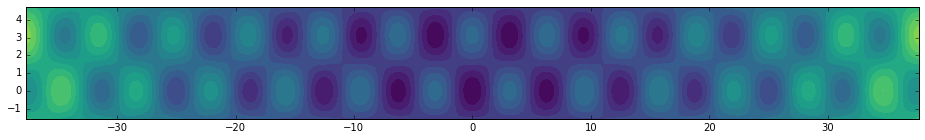

In [21]:
# zero_pi.plot_potential(countour_vals=linspace(0,2,20), aspect_ratio=0.12, filename="potential.pdf")
zero_pi.plot_potential(contour_vals=linspace(0,3,20), aspect_ratio=0.12)

### Eigenenergies

In [22]:
evals = zero_pi.eigenvals()

In [23]:
evals

array([ 0.42752059,  0.42848074,  0.45609018,  0.45690736,  0.46835442,
        0.4785273 ])


[====================] 100.0% Done.


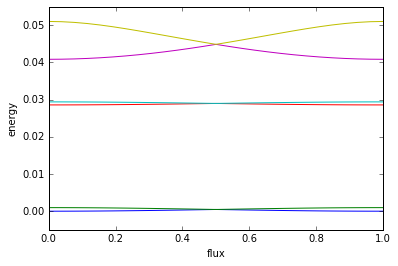

In [7]:
evals = zero_pi.eigenvals()
flux_list = np.linspace(0, 1, 27)
# zero_pi.plot_evals_vs_paramvals('flux', flux_list, shift=-evals[0], filename="./data/0pi_sym")
zero_pi.plot_evals_vs_paramvals('flux', flux_list, shift=-evals[0], yrange=[-0.005,0.055], filename="./data/0pi_sym")

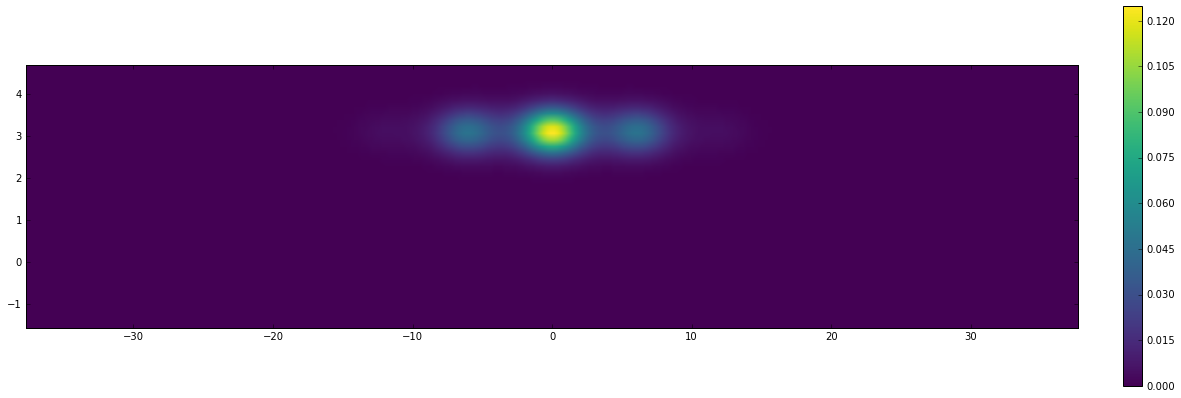

In [24]:
esys = zero_pi.eigensys()
zero_pi.plot_wavefunction(esys, which=0, mode='abs')

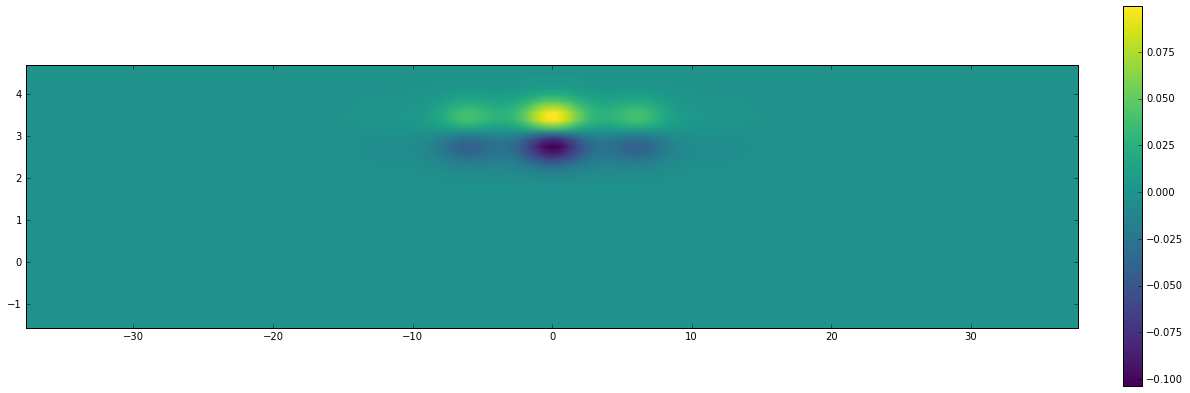

In [21]:
zero_pi.plot_wavefunction(esys=None, which=2, mode='real')

## The symmetric $0-\pi$ qubit with offset charge (no coupling to the $\chi$-mode)

$H_\text{sym}=-2E_\text{CJ}\partial_\phi^2+2E_{\text{C}\Sigma}(i\partial_\theta-n_g)^2-2E_\text{J}\cos\theta\cos(\phi-\varphi_\text{ext}/2)+E_L\phi^2+2E_\text{J}$

In [9]:
# parameters for the 0-\pi circuit

phitheta_grid = qubit.GridSpecifications(
    np.asarray([ 
        [-12*pi, 12*pi, 300], # phi variable
        [-pi/2, 3*pi/2, 40]   # theta variable (2pi periodic!)
    ])
    )



EJ_CONST = 1/3.95  # note that EJ and ECJ are interrelated

zero_pi_ng = qubit.SymZeroPiNg(
    grid = phitheta_grid,
    EJ   = EJ_CONST,
    EL   = 10.0**(-3),
    ECJ  = 1/(8.0*EJ_CONST),
    ECS  = 10.0**(-3),
    flux = 0,
    ng   = 0.2
)

In [10]:
evals=zero_pi_ng.eigenvals()

In [11]:
evals

array([ 0.42752423,  0.42848436,  0.45610058,  0.4569177 ,  0.46835834,
        0.47853109])

Note: the range in $n_g$ that converges is intimately related to the grid spacing along the $\theta$ direction. To appreciate this, remember that wavefunctions for $n_g=0$ and $n_g=1$ are identical except additional phase wrapping for the latter. This phase wrapping becomes faster and faster with $n_g$. (Specifically, the phase factor is $e^{i n_g \theta}$.)


[====================] 100.0% Done.


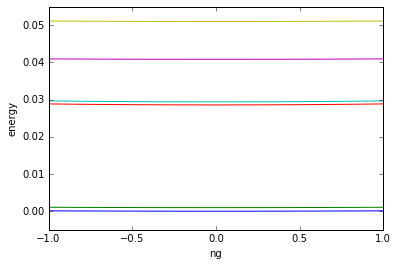

In [11]:
zero_pi_ng.flux = 0.0
zero_pi_ng.ng = 0.0

evals=zero_pi_ng.eigenvals(1)
ng_list = np.linspace(-1, 1, 12)
zero_pi_ng.plot_evals_vs_paramvals('ng', ng_list, shift=-evals[0], yrange=[-0.005,0.055])

### Plotting wave functions

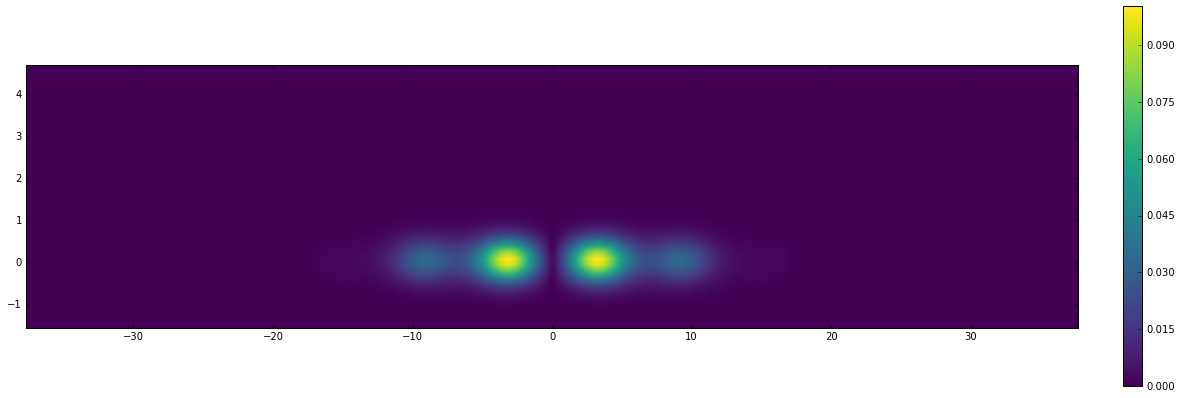

In [12]:
zero_pi_ng.ng = 0.355
esys = zero_pi_ng.eigensys(10)

zero_pi_ng.plot_wavefunction(esys, which=4, mode='abs')

## The modified symmetric $0-\pi$ qubit: substitute inductors by Josephson junctions
(suggestion by Dave, not covered in paper)

$H_\text{mod} = -2E_{C\phi}\partial_\phi^2 -2E_{C\theta}\partial_\theta^2-2E_{C\chi}\partial_\theta^2-2E_J\cos(\theta+\varphi_\text{ext}/2)\cos\phi - 2E_{J}'\cos\chi\cos\phi$

In [20]:
# parameters for the modified 0-\pi circuit


#EJ    = 1/3.95
#EJp   = 10.0**(-3)
#ECphi = 1/(8.0*pm.EJ)
#ECth  = 10.0**(-3)
#ECchi = 10.0**(-3)
#flux = 0

mod_zeropi = qubit.ModZeroPi(
    min_max_pts = np.asarray([ 
        [-pi/2, 3*pi/2, 40], # phi variable (2pi periodic!)
        [-pi/2, 3*pi/2, 40], # theta variable (2pi periodic!)
        [-pi/2, 3*pi/2, 40], # chi variable (2pi periodic!)        
    ]),
    EJ    = 1.0,
    EJp   = 1.1,
    ECphi = 1.2,
    ECth  = 1.3,
    ECchi = 1.4,
    flux  = 0.1
)

Implementation of this 0-pi device variation is still experimental & not complete


In [21]:
mod_zeropi

QUBIT PARAMETERS -------
ECchi	: 1.4
ECphi	: 1.2
ECth	: 1.3
EJ	: 1.0
EJp	: 1.1
_qubit_type	: modified symmetric 0-Pi qubit (EL->EJp)
min_max_pts	: [[ -1.57079633   4.71238898  40.        ]
 [ -1.57079633   4.71238898  40.        ]
 [ -1.57079633   4.71238898  40.        ]]
pext	: 0.1

In [22]:
mod_zeropi.eigenvals(10)

array([ 3.77340045,  5.04567667,  6.48983467,  6.52864504,  6.7520074 ,
        6.82561228,  7.88700006,  7.99414245,  8.1649993 ,  8.37670102])

## The full $0−\pi$ qubit including disorder-induced coupling to χ-mode

$H = H_\text{sym}
+4E_{C\Sigma}(\delta C_J/C_J)\partial_\phi\partial_\theta +2\,\delta E_J \sin\theta\sin(\phi-\phi_\text{ext}/2)\\
\quad-2E_C\partial_\chi^2+E_L \chi^2+4E_{C\Sigma}(\delta C/C)\partial_\theta\partial_\chi+2\,\delta E_L \phi\, \chi$

In [12]:
# grid specifications
grid3d = qubit.GridSpecifications(
    np.asarray([ 
        [-7*pi, 7*pi, 65],   # phi variable
        [-pi/2, 3*pi/2, 35], # theta variable (2pi periodic!)
        [-10.0, 10.0, 70]    # chi variable
    ])
    )


# parameters for the modified 0-\pi circuit
EJ_CONST  = 1/3.95
ECJ_CONST = 1/(8.0*EJ_CONST)
ECS_CONST = 10.0**(-3)

zeropi_full = qubit.FullZeroPi(
    grid = grid3d,
    EJ  = EJ_CONST,
    dEJ = 0.05,
    EL  = 10.0**(-3),
    dEL = 0.05,
    ECJ = ECJ_CONST,
    dCJ = 0.05,
    ECS = ECS_CONST,
    EC  = 1/(1/ECS_CONST-1/ECJ_CONST),
    dC  = 0.08,
    flux = 0
)

In [13]:
zeropi_full

full 0-Pi circuit (phi, theta, chi), no offset charge -- PARAMETERS -------
EC	: 0.00100202942669
ECJ	: 0.49375
ECS	: 0.001
EJ	: 0.253164556962
EL	: 0.001
dC	: 0.08
dCJ	: 0.05
dEJ	: 0.05
dEL	: 0.05
flux	: 0
grid	:     Grid ......
max_vals	: [ 21.99114858   4.71238898  10.        ]
min_vals	: [-21.99114858  -1.57079633 -10.        ]
pt_counts	: [ 65.  35.  70.]
var_count	: 3
Hilbert space dimension	: 159250

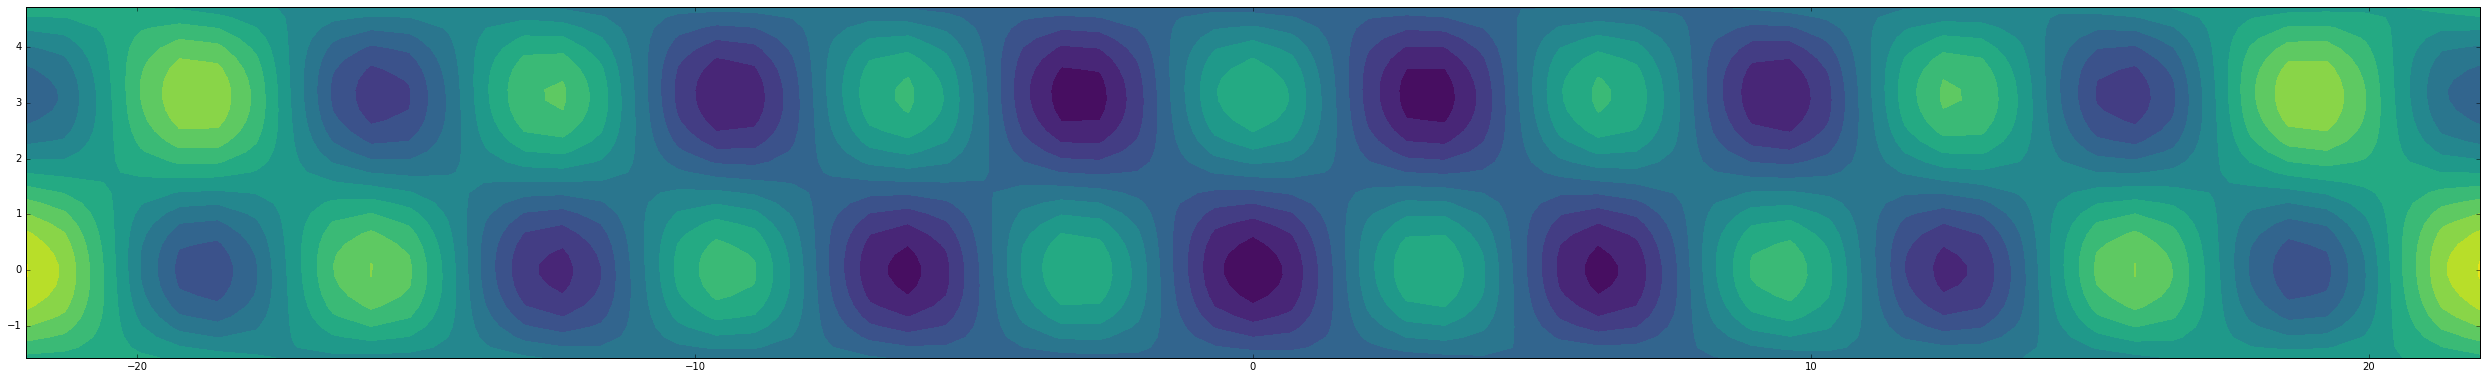

In [14]:
# zeropi_full.plot_potential('theta', 0.0, levels=linspace(0,1.63,20))
zeropi_full.plot_potential('chi', 0.0, contour_vals=linspace(0,1.63,15))

In [15]:
ev0 = zeropi_full.eigenvals(evals_count=2)
print(ev0[0])

0.453696754936


In [ ]:
flux_list = np.linspace(0, 2*pi, 27)
zeropi_full.plot_evals_vs_paramvals('flux', flux_list, evals_count=40, shift=-ev0[0], filename="./data/0pifull_E_vs_flux")

In [21]:
# evals, evecs = zeropi_full.eigensys(40, filename="./data/0pi_disordered")
evals, evecs = zeropi_full.eigensys(evals_count=3)

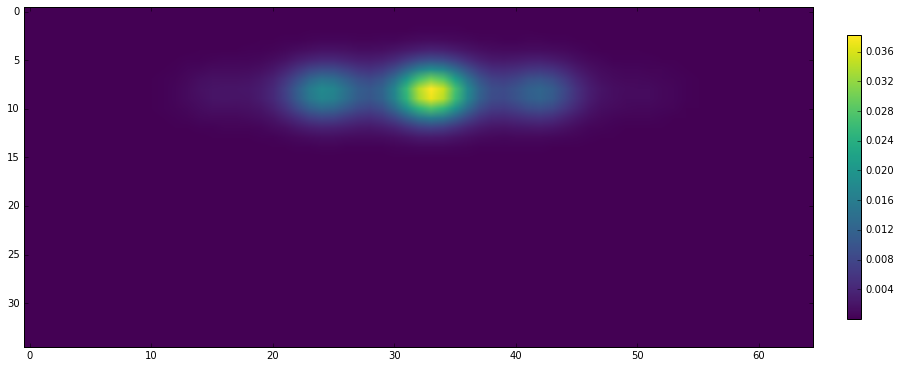

In [23]:
zeropi_full.plot_wavefunction(esys=(evals,evecs), fixedvar_name='chi', fixedvar_val=-0.5, which=2, mode='real', figsize=(15,15), aspect_ratio=0.8)

Note: for the parameters chosen here (and similar to what the "ideal" 0-pi device should have), it is evident that spatial discretization is problematic for the $\chi$ degree of freedom. This degree is so low-energetic that it will acquire a large number of nodes/antinodes before other excitations occur. These nodes/antinodes will be densely spaced, going beyond the spatial discretization and hence causing errors (seen as deviations from equidistant spacing of energy levels for the case without disorder).

## $0-\pi$ qubit with disorder in $E_J$ and $E_C$ ($\chi$ remains decoupled)

$H = H_\text{sym}
+4E_{C\Sigma}(\delta C_J/C_J)\partial_\phi\partial_\theta +2\,\delta E_J \sin\theta\sin(\phi-\phi_\text{ext}/2)$

In [16]:
phitheta_grid = qubit.GridSpecifications(
    np.asarray([ 
        [-8*pi, 8*pi, 360],  # phi variable
        [-pi/2, 3*pi/2, 55] # theta variable (periodic!)
    ])
    )


# parameters
EJ_CONST = 1/3.95

zeropi_dis = qubit.DisZeroPi(
    grid = phitheta_grid,
    EJ  = EJ_CONST,
    dEJ = 0.1,
    EL  = 10.0**(-3),
    ECJ = 1 / (8.0*EJ_CONST),
    dCJ = 0.1,
    ECS  = 10.0**(-3),
    flux = 0
)

In [17]:
zeropi_dis

0-Pi qubit with EJ and CJ disorder, no coupling to chi mode (zero offset charge) -- PARAMETERS -------
ECJ	: 0.49375
ECS	: 0.001
EJ	: 0.253164556962
EL	: 0.001
dCJ	: 0.1
dEJ	: 0.1
flux	: 0
grid	:     Grid ......
max_vals	: [ 25.13274123   4.71238898]
min_vals	: [-25.13274123  -1.57079633]
pt_counts	: [ 360.   55.]
var_count	: 2
Hilbert space dimension	: 19800

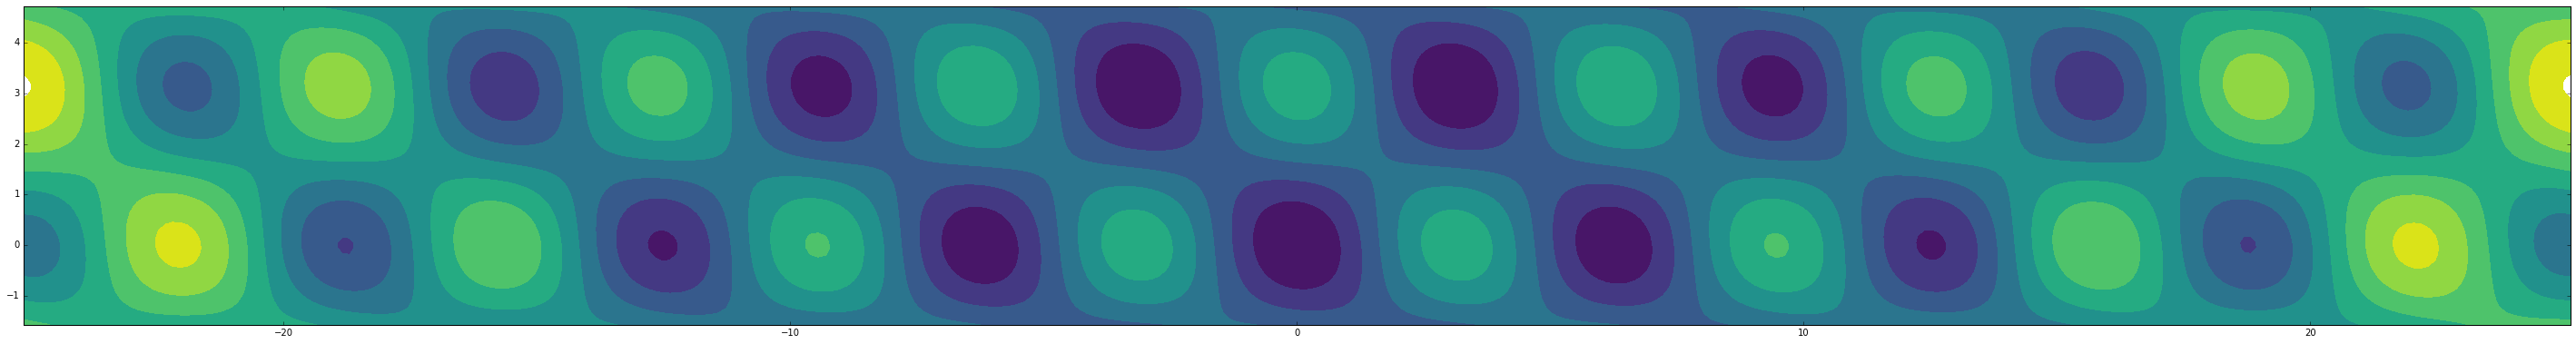

In [18]:
zeropi_dis.plot_potential(contour_vals=linspace(0,1.63,10))

In [19]:
evals = zeropi_dis.eigenvals(evals_count=4)
print(evals)

[ 0.42765344  0.42861587  0.45614867  0.45696385]


In [ ]:
flux_list = np.linspace(0, 2*pi, 27)
zeropi_dis.plot_evals_vs_paramvals('flux', flux_list, shift=-evals[0], yrange=[-0.005,0.055], filename="./data/0pi_dis_E_vs_flux")

Note: as soon as $E_J$ disorder is included, the potential is not perfectly symmetric w.r.t. $\phi=0$ anymore, so small matrix elements between same-rung wavefunctions with nominally same parity are to be expected.

## Full $0-\pi$ circuit in product basis (all disorder types and coupling to $\chi$ mode)

In [20]:
phitheta_grid = qubit.GridSpecifications(
    np.asarray([ 
        [-8*pi, 8*pi, 360],  # phi variable
        [-pi/2, 3*pi/2, 55] # theta variable (periodic!)
    ])
    )

# parameters for the modified 0-\pi circuit
EJ_CONST  = 1/3.95
ECJ_CONST = 1/(8.0*EJ_CONST)
ECS_CONST = 10.0**(-3)

zpifull = qubit.FullZeroPi_ProductBasis(
    zeropi_cutoff = 10,
    chi_cutoff = 40,
    grid = phitheta_grid,
    EJ  = EJ_CONST,
    dEJ = 0.05,
    EL  = 10.0**(-3),
    dEL = 0.05,
    ECJ = ECJ_CONST,
    dCJ = 0.05,
    ECS = ECS_CONST,
    EC  = 1/(1/ECS_CONST-1/ECJ_CONST),
    dC  = 0.08,
    flux = 0
)

In [21]:
zpifull

full 0-Pi circuit (phi, theta, chi) in 0pi - chi product basis -- PARAMETERS -------
EC	: 0.00100202942669
ECJ	: 0.49375
ECS	: 0.001
EJ	: 0.253164556962
EL	: 0.001
chi_cutoff	: 40
dC	: 0.08
dCJ	: 0.05
dEJ	: 0.05
dEL	: 0.05
flux	: 0
grid	:     Grid ......
max_vals	: [ 25.13274123   4.71238898]
min_vals	: [-25.13274123  -1.57079633]
pt_counts	: [ 360.   55.]
var_count	: 2
zeropi_cutoff	: 10
Hilbert space dimension	: 400

In [22]:
evals2 = zpifull.eigenvals(evals_count=40)
evals2 - evals2[0]

array([ 0.        ,  0.00096145,  0.00281964,  0.00377939,  0.00563929,
        0.00659733,  0.00845894,  0.00941528,  0.01127859,  0.01223322,
        0.01409825,  0.01505117,  0.01691791,  0.01786912,  0.01973757,
        0.02068707,  0.02255724,  0.02350502,  0.02537691,  0.02632298,
        0.02819659,  0.02861525,  0.02914094,  0.02942929,  0.03101627,
        0.03143803,  0.0319589 ,  0.03224781,  0.03383596,  0.03426082,
        0.03477686,  0.03506636,  0.03665565,  0.03708363,  0.03759483,
        0.03788496,  0.03947534,  0.03990647,  0.04041279,  0.0407036 ])

### Matrix elements $g_{ll'}$ [Dempster et al., text immediately above Eqs. (17) & (18)]

In [23]:
ev_count = 10
gmat = zpifull.g_coupling_matrix(None, evals_count=ev_count)

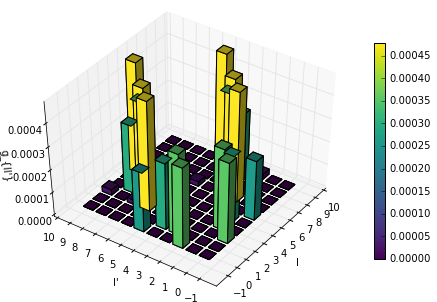

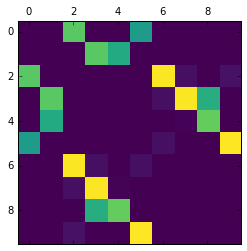

In [24]:
qubit.plot_matrixelements(gmat, xlabel="l", ylabel="l'", zlabel="g_{ll'}")

# Interfacing with qutip

## Example: two Cooper pair boxes coupled to one resonator mode
$\displaystyle H=\sum_{\alpha=1,2}\sum_{j} E_j^{(\alpha)}|\alpha j\rangle\langle \alpha j| + \omega_r a^\dagger a + \sum_{\alpha=1,2}\sum_{j,k}g^{(\alpha)}_{jk} |\alpha j\rangle \langle \alpha k|(a+a^\dagger)$

### Define Hilbert space components, Hilbert space tuple, and system operators

In [2]:
# Set up the components / subspaces of our Hilbert space
# Objects may be taken from sc_qubits; for resonators or other
# elements not covered, the class GenericQSys is provided in
# the qubitwrapper module

CPB1 = qubit.Transmon(
    EJ = 40.0,
    EC = 0.2,
    ng = 0.0,
    ncut = 40,
    truncated_dim = 3     # after diagonalization, we will keep 3 levels
)

CPB2 = qubit.Transmon(
    EJ = 3.0,
    EC = 1.0,
    ng = 0.0,
    ncut = 10,
    truncated_dim = 4
)

resonator = qubit.Oscillator(
    omega = 6.0,
    truncated_dim=4  # up to 3 photons (0,1,2,3)
)


# Form a list of all components making up the Hilbert space.
hilbertspc = qubit.HilbertSpace([CPB1, CPB2, resonator])

In [3]:
hilbertspc

====== HILBERT SPACE OBJECT ======
subsystem_list	: [Cooper pair box -- PARAMETERS -------
EC	: 0.2
EJ	: 40.0
ncut	: 40
ng	: 0.0
truncated_dim	: 3
Hilbert space dimension	: 81, Cooper pair box -- PARAMETERS -------
EC	: 1.0
EJ	: 3.0
ncut	: 10
ng	: 0.0
truncated_dim	: 4
Hilbert space dimension	: 21, Oscillator -- PARAMETERS -------
truncated_dim	: 4
omega	: 6.0]

dimension	: 48

subsystem_count	: 3

subsystem_dims	: [3, 4, 4]

In [4]:
# Get resonator Hamiltonian (full product Hilbert space)
hres = hilbertspc.diag_hamiltonian(resonator)

# Get diagonalized CPB1 Hamiltonian as full-system operator via tensor product with identities.
h1 = hilbertspc.diag_hamiltonian(CPB1)

# Get diagonalized CPB2 Hamiltonian as full-system operator via tensor product with identities.
h2 = hilbertspc.diag_hamiltonian(CPB2)

### Additional system parameters

In [5]:
g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

dim1 = CPB1.truncated_dim
dim2 = CPB2.truncated_dim

_, evecs1 = CPB1.eigensys(dim1)
_, evecs2 = CPB2.eigensys(dim2)
gmat1 = g1 * qubit.matrixelem_table(CPB1.n_operator(), evecs1)   # coupling constants for CPB1
gmat2 = g2 * qubit.matrixelem_table(CPB2.n_operator(), evecs2)   # and for CPB2

In [6]:
hbd = hilbertspc.hubbard_operator

a = hilbertspc.annihilate(resonator)

hamiltonian0 = h1 + h2 + hres

vcpb1 = sum([gmat1[j][k] * hbd(j,k,CPB1) for j in range(dim1) for k in range(dim1)])
vcpb2 = sum([gmat2[j][k] * hbd(j,k,CPB2) for j in range(dim2) for k in range(dim2)])

hamiltonian1 = (vcpb1 + vcpb2) * (a + a.dag())

hamiltonian = hamiltonian0 + hamiltonian1

In [7]:
evals = hamiltonian.eigenenergies()
evals - evals[0]

array([  0.        ,   4.7413544 ,   5.67735222,   5.98950905,
         7.80640354,  10.72322062,  11.66010887,  11.97899397,
        12.54774214,  13.48373921,  13.79336706,  15.40788822,
        16.70536671,  17.0107636 ,  17.64299395,  17.97765509,
        18.52707468,  19.46396103,  19.7814319 ,  20.14938419,
        21.08524034,  21.44455868,  22.73476831,  22.99570336,
        23.65966864,  24.50777475,  24.817159  ,  25.44567465,
        25.73329529,  26.17864385,  27.11527495,  27.47976701,
        28.98060932,  30.48965573,  30.79955284,  31.41462898,
        32.20631135,  32.41862923,  33.14439016,  33.40596931,
        34.9719839 ,  36.78300465,  38.16292564,  38.45084631,
        39.08764588,  42.72733279,  44.48150766,  50.3995315 ])

In [8]:
# Example: spectrum when varying the Josephson energy of CPB1 via a flux
# Set up Hamiltonian:

ham0 = h2 + hres

vcpb2 = sum([gmat2[j][k] * hbd(j,k,CPB2) for j in range(dim2) for k in range(dim2)])

def hamiltonian(flux):
    CPB1.EJ = 40.0 * cos(pi*flux)
    h1 = hilbertspc.diag_hamiltonian(CPB1)
    vcpb1 = sum([gmat1[j][k] * hbd(j,k,CPB1) for j in range(dim1) for k in range(dim1)])
    
    return (h1 + ham0 + (vcpb1 + vcpb2) * (a + a.dag()))

In [11]:
spectest = hilbertspc.emission_spectrum(hamiltonian(0.3), bare_initial_state=((CPB1,0), (CPB2,0), (resonator,1)))
spectest

array([ 6.12407441,  1.38279244,  0.4467277 ,  0.32114729, -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [12]:
flux_list = np.linspace(0, 1, 320)
spec_func = hilbertspc.absorption_spectrum

specdata = hilbertspc.spectrum_vs_paramvals(spec_func, hamiltonian, flux_list)


[====================] 100.0% Done.


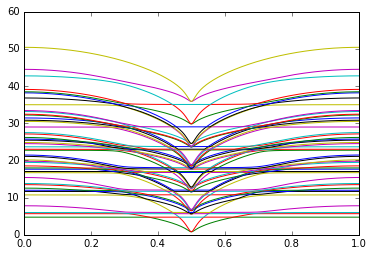

In [13]:
plt.plot(flux_list, specdata)
plt.show()

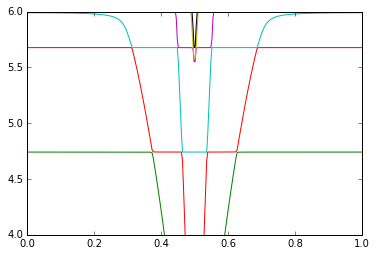

In [14]:
plt.plot(flux_list, specdata)
plt.ylim(4,6)
plt.show()

In [15]:
spec_func = hilbertspc.emission_spectrum

specdata = hilbertspc.spectrum_vs_paramvals(spec_func, hamiltonian, flux_list, bare_initial_state=((CPB1,0),(CPB2,0),(resonator,1)))


[====================] 100.0% Done.


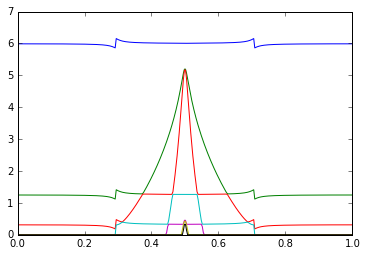

In [16]:
plt.plot(flux_list, specdata)
plt.show()